***Logistic Regression on basic numerical data sentiment based TSS***

In [1]:
print("Hello, Colab!")

Hello, Colab!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np

# For splitting data and scaling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns

# For balancing data classes
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Logistic Regression model and evaluation metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report
from sklearn.feature_selection import RFE



In [5]:
# Load the dataset
file_path = '/content/drive/My Drive/nlp/dataset_final/finsen_s&p500/FinSen_text_annotated.csv'
file_path_num = '/content/drive/My Drive/nlp/dataset_final/finsen_s&p500/numerical_S&P500.csv'

data = pd.read_csv(file_path_num)
data_sent = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data_sent.head())

   Unnamed: 0                                  Title           Tag  \
0           0  TSX Slightly Down, Books Weekly Gains  Stock Market   
1           1          UnitedHealth Hits 4-week High        stocks   
2           2          Cisco Systems Hits 4-week Low        stocks   
3           3                 AT&T Hits All-time Low        stocks   
4           4             Microsoft Hits 4-week High        stocks   

         Time                                            Content  \
0  16/07/2023  TSX Slightly Down, Books Weekly GainsUnited St...   
1  15/07/2023  UnitedHealth Hits 4-week HighUnited States sto...   
2  15/07/2023  Cisco Systems Hits 4-week LowUnited States sto...   
3  15/07/2023  AT&T Hits All-time LowUnited States stocksAT&T...   
4  15/07/2023  Microsoft Hits 4-week HighUnited States stocks...   

   sentiment_score  
0             0.13  
1             0.62  
2            -0.43  
3            -0.28  
4             0.60  


In [6]:
# Check if 'Unnamed: 0' exists in the columns and drop it
if 'Unnamed: 0' in data_sent.columns:
    data_sent = data_sent.drop(columns=['Unnamed: 0'])
data_sent.rename(columns={'Time': 'Date'}, inplace=True)
data_sent.head()

,Title,Tag,Date,Content,sentiment_score
0,"TSX Slightly Down, Books Weekly Gains",Stock Market,16/07/2023,"TSX Slightly Down, Books Weekly GainsUnited St...",0.13
1,UnitedHealth Hits 4-week High,stocks,15/07/2023,UnitedHealth Hits 4-week HighUnited States sto...,0.62
2,Cisco Systems Hits 4-week Low,stocks,15/07/2023,Cisco Systems Hits 4-week LowUnited States sto...,-0.43
3,AT&T Hits All-time Low,stocks,15/07/2023,AT&T Hits All-time LowUnited States stocksAT&T...,-0.28
4,Microsoft Hits 4-week High,stocks,15/07/2023,Microsoft Hits 4-week HighUnited States stocks...,0.60


In [7]:
# Ensure the Date columns are in datetime format in both DataFrames
data_sent['Date'] = pd.to_datetime(data_sent['Date'])
data['Date'] = pd.to_datetime(data['Date'])


# Calculate the aggregate sentiment score for each date in sentiment_data
aggregate_sentiment = data_sent.groupby('Date', as_index=False)['sentiment_score'].sum()
aggregate_sentiment.rename(columns={'sentiment_score': 'aggregate_sentiment_score'}, inplace=True)

# Merge the stock data (data) with the aggregated sentiment data
merged_data = pd.merge(data, aggregate_sentiment, on='Date', how='inner')

# Select the required columns
final_data = merged_data[['Date', 'Open', 'Close', 'High', 'Volume', 'aggregate_sentiment_score']]

# Inspect the final DataFrame
final_data.head()


/tmp/ipython-input-714286241.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data_sent['Date'] = pd.to_datetime(data_sent['Date'])


,Date,Open,Close,High,Volume,aggregate_sentiment_score
0,2007-06-21,1512.50,1522.18,1522.90,3.161110e+09,0.03
1,2007-06-26,1497.68,1492.89,1506.11,3.398530e+09,-0.66
2,2007-06-28,1506.31,1505.70,1514.83,3.006710e+09,0.16
3,2007-07-05,1524.85,1525.40,1526.56,2.622950e+09,0.66
4,2007-07-06,1524.95,1530.43,1532.40,2.441520e+09,-0.02


In [8]:
# Calculate next-day return
final_data['Movement'] = ((final_data['Open'].shift(-1) - final_data['Close']) / data['Close'])

# Shift Movement to align with current day
final_data['Movement'] = final_data['Movement'].shift(1)

# Drop the last row because there's no next day to compare
final_data = final_data.dropna(subset=['Movement'])

# Convert Movement into binary (1 for up if Movement > 0, else 0)
final_data['Movement'] = (final_data['Movement'] > 0).astype(int)

# Calculate daily returns (in percentage)
final_data['Daily_Return'] = final_data['Close'].pct_change() * 100

# Choose a rolling window (e.g., 10 days) for volatility
window_size = 5
final_data['Volatility'] = final_data['Daily_Return'].rolling(window=window_size).std()

# Drop the initial NaNs from rolling calculation
final_data = final_data.dropna(subset=['Volatility'])

# Define a rolling window size for sentiment volatility
sentiment_window_size = 5  # You can adjust the window size as needed

# Calculate rolling standard deviation of the aggregate sentiment score
final_data['sentiment_volatility'] = final_data['aggregate_sentiment_score'].rolling(window=sentiment_window_size).std()

# Create lagged sentiment volatility to avoid data leakage
final_data['sentiment_volatility_lag1'] = final_data['sentiment_volatility'].shift(1)

# Create lagged sentiment volatility to avoid data leakage
final_data['aggregate_sentiment_score_lag1'] = final_data['aggregate_sentiment_score'].shift(1)

# Drop rows with NaN values introduced by rolling and shifting
final_data = final_data.dropna(subset=['sentiment_volatility_lag1', 'aggregate_sentiment_score_lag1'])

# Create lagged features to avoid data leakage
final_data['Close_lag1'] = final_data['Close'].shift(1)
final_data['High_lag1'] = final_data['High'].shift(1)
final_data['Volume_lag1'] = final_data['Volume'].shift(1)
final_data['Daily_Return_lag1'] = final_data['Daily_Return'].shift(1)
final_data['Volatility_lag1'] = final_data['Volatility'].shift(1)

# Drop rows with NaN values introduced by shifting
final_data = final_data.dropna(subset=['Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1', 'sentiment_volatility_lag1'])


final_data.head(10)

/tmp/ipython-input-3626410606.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['Movement'] = ((final_data['Open'].shift(-1) - final_data['Close']) / data['Close'])
/tmp/ipython-input-3626410606.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['Movement'] = final_data['Movement'].shift(1)


,Date,Open,Close,High,Volume,aggregate_sentiment_score,Movement,Daily_Return,Volatility,sentiment_volatility,sentiment_volatility_lag1,aggregate_sentiment_score_lag1,Close_lag1,High_lag1,Volume_lag1,Daily_Return_lag1,Volatility_lag1
12,2007-08-01,1455.18,1465.81,1468.38,5.256780e+09,-0.15,0,0.724264,1.257202,0.270222,0.268142,0.00,1455.27,1488.30,4.524520e+09,-0.251552,0.991957
13,2007-08-07,1467.61,1476.70,1488.30,4.909390e+09,0.00,1,0.742934,1.384401,0.262336,0.270222,-0.15,1465.81,1468.38,5.256780e+09,0.724264,1.257202
14,2007-08-10,1453.08,1453.64,1462.02,5.345780e+09,-0.67,0,-1.561590,1.159805,0.367736,0.262336,0.00,1476.70,1488.30,4.909390e+09,0.742934,1.384401
15,2007-08-13,1453.42,1452.92,1466.29,3.696280e+09,-0.20,0,-0.049531,0.942009,0.275372,0.367736,-0.67,1453.64,1462.02,5.345780e+09,-1.561590,1.159805
16,2007-08-14,1452.86,1426.54,1456.73,3.814630e+09,-0.23,0,-1.815654,1.229445,0.250898,0.275372,-0.20,1452.92,1466.29,3.696280e+09,-0.049531,0.942009
17,2007-08-15,1426.15,1406.69,1440.78,4.290930e+09,-0.10,0,-1.391479,1.107264,0.256807,0.250898,-0.23,1426.54,1456.73,3.814630e+09,-1.815654,1.229445
18,2007-08-16,1406.64,1411.27,1415.96,6.509300e+09,0.01,0,0.325587,0.967345,0.259172,0.256807,-0.10,1406.69,1440.78,4.290930e+09,-1.391479,1.107264
19,2007-08-17,1411.26,1445.93,1450.32,3.570040e+09,0.00,0,2.455944,1.682839,0.110589,0.259172,0.01,1411.27,1415.96,6.509300e+09,0.325587,0.967345
20,2007-08-20,1445.93,1445.55,1451.75,3.321340e+09,-0.05,0,-0.026281,1.683028,0.097622,0.110589,0.00,1445.93,1450.32,3.570040e+09,2.455944,1.682839
21,2007-08-28,1466.71,1432.35,1466.71,3.078090e+09,-1.13,1,-0.913147,1.488942,0.491660,0.097622,-0.05,1445.55,1451.75,3.321340e+09,-0.026281,1.683028


In [9]:
final_data.columns

Index(['Date', 'Open', 'Close', 'High', 'Volume', 'aggregate_sentiment_score',
       'Movement', 'Daily_Return', 'Volatility', 'sentiment_volatility',
       'sentiment_volatility_lag1', 'aggregate_sentiment_score_lag1',
       'Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1',
       'Volatility_lag1'],
      dtype='object')

In [10]:
# Correlation Metrics
# Specify the columns of interest for correlation with 'Movement'
columns_of_interest = ['aggregate_sentiment_score', 'sentiment_volatility', 'sentiment_volatility_lag1', 'aggregate_sentiment_score_lag1']

# Calculate the correlation between 'Movement' and each of the specified columns
correlation_with_movement = final_data[columns_of_interest + ['Movement']].corr()['Movement']

# Drop the self-correlation of 'Movement'
correlation_with_movement = correlation_with_movement.drop('Movement')

# Display the correlation values
print(correlation_with_movement)


aggregate_sentiment_score         0.307574
sentiment_volatility              0.019800
sentiment_volatility_lag1         0.028496
aggregate_sentiment_score_lag1   -0.019771
Name: Movement, dtype: float64


In [11]:
# Define features (X) and target (y)
features = ['Open', 'Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1', 'aggregate_sentiment_score_lag1', 'sentiment_volatility_lag1']
X = final_data[features]
y = final_data['Movement']


In [12]:
# Ensure the 'Date' column is in datetime format
final_data['Date'] = pd.to_datetime(final_data['Date'])  # Ensure correct datetime format
final_data.set_index('Date', inplace=True)
print(final_data.index)


DatetimeIndex(['2007-08-01', '2007-08-07', '2007-08-10', '2007-08-13',
               '2007-08-14', '2007-08-15', '2007-08-16', '2007-08-17',
               '2007-08-20', '2007-08-28',
               ...
               '2023-06-27', '2023-06-28', '2023-06-29', '2023-06-30',
               '2023-07-06', '2023-07-07', '2023-07-11', '2023-07-12',
               '2023-07-13', '2023-07-14'],
              dtype='datetime64[ns]', name='Date', length=2800, freq=None)


In [13]:
X.index = final_data.index
print(X.index)

DatetimeIndex(['2007-08-01', '2007-08-07', '2007-08-10', '2007-08-13',
               '2007-08-14', '2007-08-15', '2007-08-16', '2007-08-17',
               '2007-08-20', '2007-08-28',
               ...
               '2023-06-27', '2023-06-28', '2023-06-29', '2023-06-30',
               '2023-07-06', '2023-07-07', '2023-07-11', '2023-07-12',
               '2023-07-13', '2023-07-14'],
              dtype='datetime64[ns]', name='Date', length=2800, freq=None)


In [14]:
# Initialize lists to store train and test years
# Initialize TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5)
train_years = []
test_years = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Map the integer indices back to the DatetimeIndex
    train_dates = X.index[train_index]
    test_dates = X.index[test_index]

    # Store the dates
    train_years.append(train_dates)
    test_years.append(test_dates)

    # Print the date range for each fold (optional)
    print(f"Fold {fold + 1}:")
    print(f"Train Dates: {train_dates.min().strftime('%Y-%m-%d')} to {train_dates.max().strftime('%Y-%m-%d')}")
    print(f"Test Dates: {test_dates.min().strftime('%Y-%m-%d')} to {test_dates.max().strftime('%Y-%m-%d')}")
    print("-" * 50)


Fold 1:
Train Dates: 2007-08-01 to 2012-09-11
Test Dates: 2012-09-13 to 2015-12-07
--------------------------------------------------
Fold 2:
Train Dates: 2007-08-01 to 2015-12-07
Test Dates: 2015-12-08 to 2017-10-19
--------------------------------------------------
Fold 3:
Train Dates: 2007-08-01 to 2017-10-19
Test Dates: 2017-10-20 to 2019-10-11
--------------------------------------------------
Fold 4:
Train Dates: 2007-08-01 to 2019-10-11
Test Dates: 2019-10-15 to 2021-08-30
--------------------------------------------------
Fold 5:
Train Dates: 2007-08-01 to 2021-08-30
Test Dates: 2021-08-31 to 2023-07-14
--------------------------------------------------


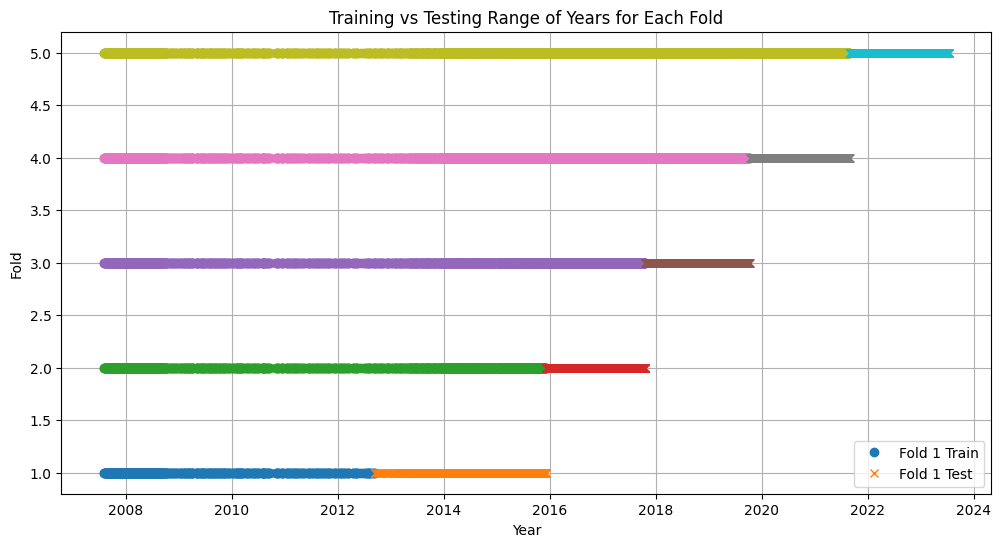

In [15]:
# Plot training vs testing years
plt.figure(figsize=(12, 6))

for i, (train, test) in enumerate(zip(train_years, test_years)):
    plt.plot(train, [i + 1] * len(train), 'o', label=f'Fold {i + 1} Train' if i == 0 else "")
    plt.plot(test, [i + 1] * len(test), 'x', label=f'Fold {i + 1} Test' if i == 0 else "")

plt.xlabel('Year')
plt.ylabel('Fold')
plt.title('Training vs Testing Range of Years for Each Fold')
plt.legend(loc='lower right')
plt.grid()
plt.show()



Fold 1 Confusion Matrix:
[[202   4]
 [156 104]]


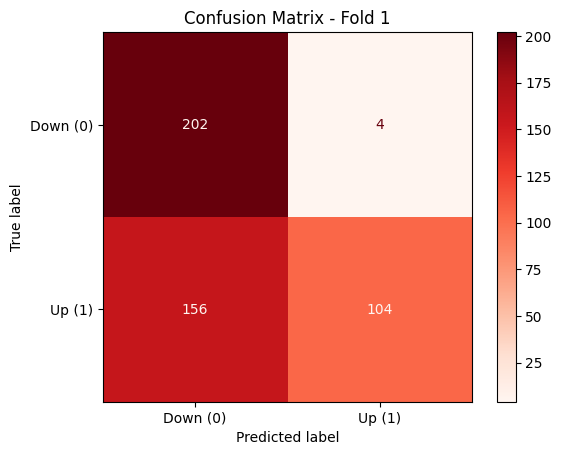

Fold 1 Accuracy: 0.66
--------------------------------------------------

Fold 2 Confusion Matrix:
[[ 53 162]
 [ 31 220]]


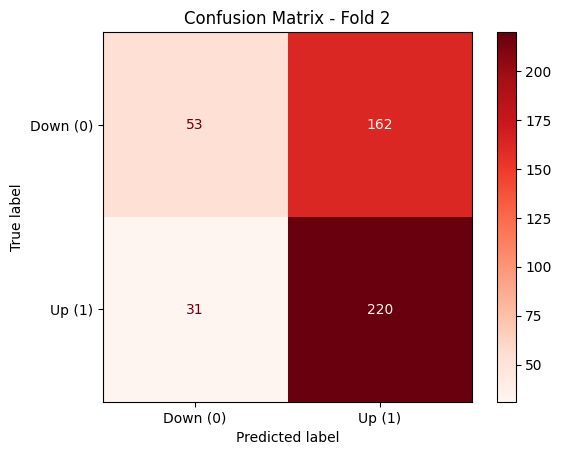

Fold 2 Accuracy: 0.59
--------------------------------------------------

Fold 3 Confusion Matrix:
[[ 24 168]
 [  0 274]]


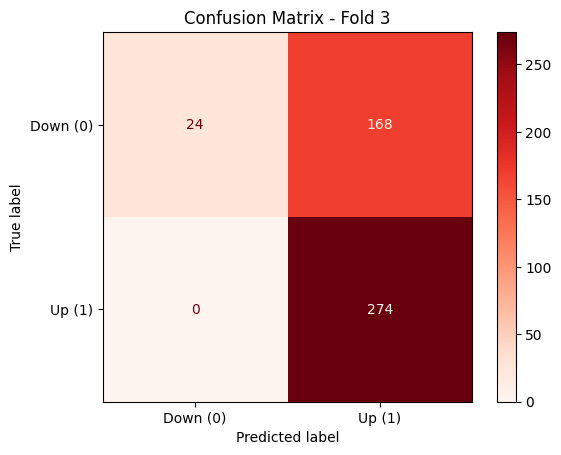

Fold 3 Accuracy: 0.64
--------------------------------------------------

Fold 4 Confusion Matrix:
[[ 34 147]
 [  0 285]]


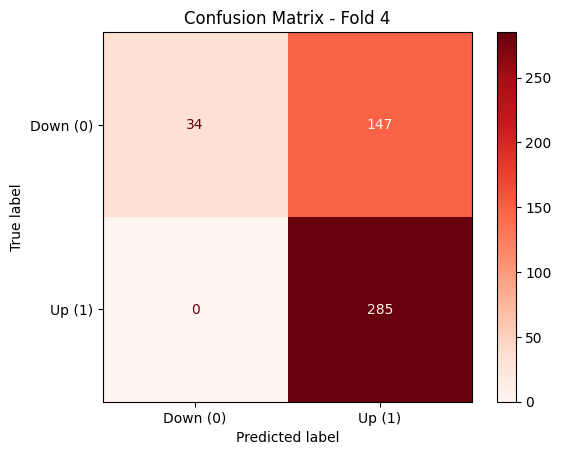

Fold 4 Accuracy: 0.68
--------------------------------------------------

Fold 5 Confusion Matrix:
[[  8 228]
 [  0 230]]


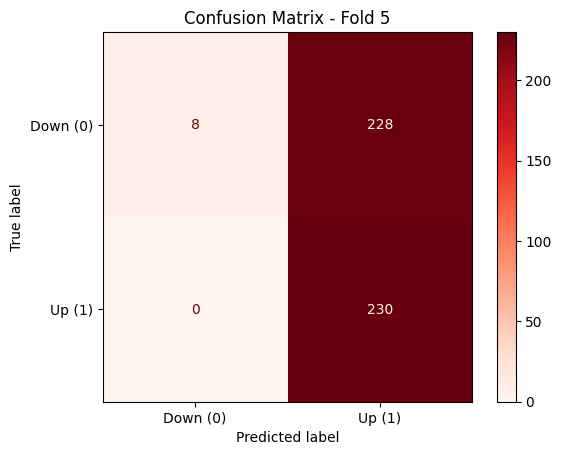

Fold 5 Accuracy: 0.51
--------------------------------------------------

Average Metrics Across Folds:
Accuracy: 0.62
Precision: 0.66
Recall: 0.86
F1-Score: 0.70
ROC-AUC: 0.82

Cross-Validation Accuracy: 0.6155 ± 0.0615


In [16]:
# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and train the Logistic Regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Append metrics for each fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nFold {fold + 1} Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
    disp.plot(cmap="Reds")
    disp.ax_.set_title(f"Confusion Matrix - Fold {fold + 1}")
    plt.savefig(f'confusion_matrix_sentiment_unbalanced_fold_{fold+1}.png')
    plt.show()

    # Print accuracy for the fold
    print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}")
    print("-" * 50)

# Print average metrics
print("\nAverage Metrics Across Folds:")
print(f"Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}")
print(f"Precision: {sum(precision_scores) / len(precision_scores):.2f}")
print(f"Recall: {sum(recall_scores) / len(recall_scores):.2f}")
print(f"F1-Score: {sum(f1_scores) / len(f1_scores):.2f}")
print(f"ROC-AUC: {sum(roc_auc_scores) / len(roc_auc_scores):.2f}")

mean_acc = np.mean(accuracy_scores)
std_acc = np.std(accuracy_scores)
print(f"\nCross-Validation Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


Fold 1 - Balanced Class Distribution:
Movement
0    232
1    232
Name: count, dtype: int64
--------------------------------------------------

Fold 1 Confusion Matrix:
[[191  15]
 [136 124]]


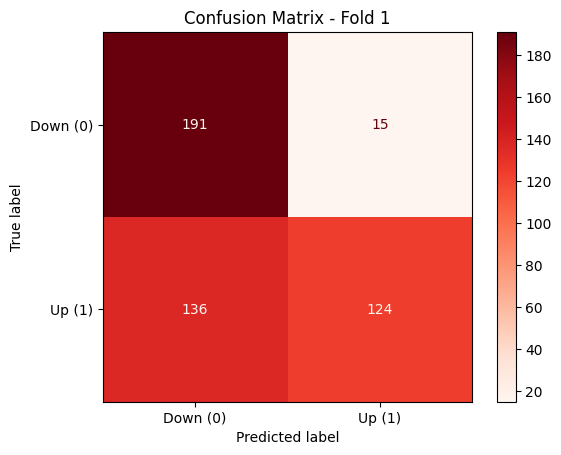

Fold 1 Accuracy: 0.68
--------------------------------------------------
Fold 2 - Balanced Class Distribution:
Movement
0    444
1    444
Name: count, dtype: int64
--------------------------------------------------

Fold 2 Confusion Matrix:
[[118  97]
 [ 92 159]]


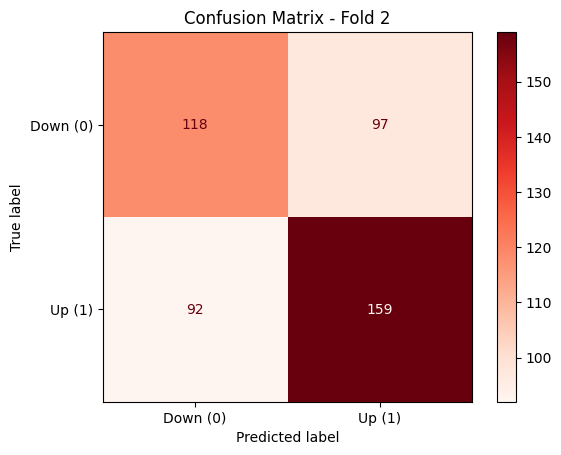

Fold 2 Accuracy: 0.59
--------------------------------------------------
Fold 3 - Balanced Class Distribution:
Movement
0    659
1    659
Name: count, dtype: int64
--------------------------------------------------

Fold 3 Confusion Matrix:
[[ 68 124]
 [  8 266]]


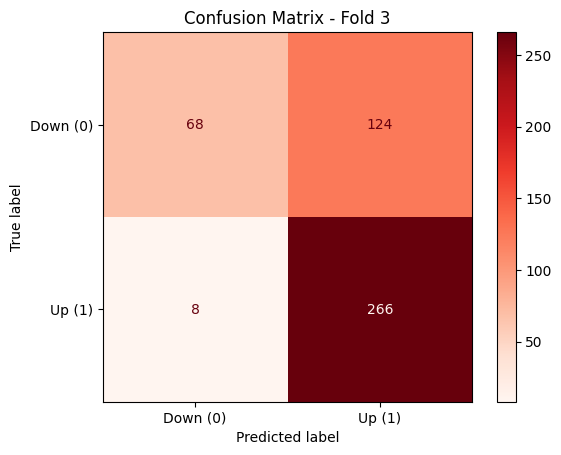

Fold 3 Accuracy: 0.72
--------------------------------------------------
Fold 4 - Balanced Class Distribution:
Movement
0    851
1    851
Name: count, dtype: int64
--------------------------------------------------

Fold 4 Confusion Matrix:
[[ 48 133]
 [  1 284]]


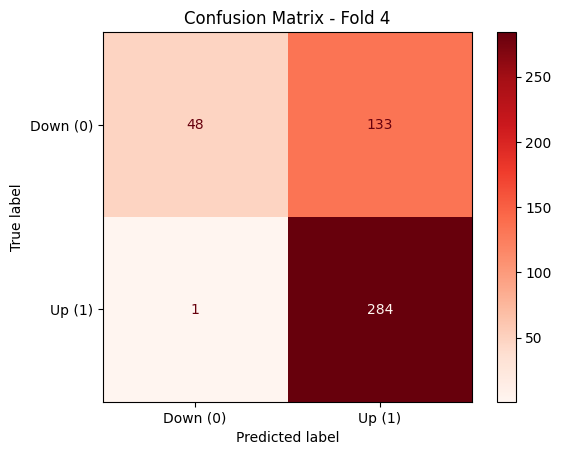

Fold 4 Accuracy: 0.71
--------------------------------------------------
Fold 5 - Balanced Class Distribution:
Movement
0    1032
1    1032
Name: count, dtype: int64
--------------------------------------------------

Fold 5 Confusion Matrix:
[[ 40 196]
 [  2 228]]


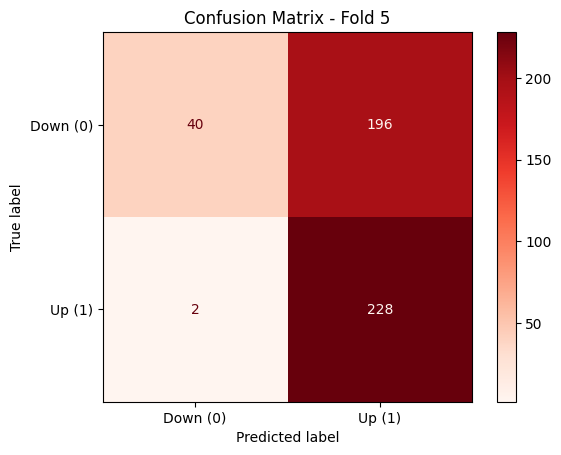

Fold 5 Accuracy: 0.58
--------------------------------------------------

Average Metrics Across Folds (Balanced Data):
Accuracy: 0.65
Precision: 0.68
Recall: 0.81
F1-Score: 0.71
ROC-AUC: 0.80

Cross-Validation Accuracy: 0.6549 ± 0.0593


In [17]:
# Initialize SMOTE for balancing the dataset
undersampler = RandomUnderSampler(random_state=42)

# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Balance the training data
    X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

    # Print class distribution for the balanced training data
    print(f"Fold {fold + 1} - Balanced Class Distribution:")
    print(y_train_balanced.value_counts())
    print("-" * 50)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and train the Logistic Regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train_balanced)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Append metrics for each fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nFold {fold + 1} Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
    disp.plot(cmap="Reds")
    disp.ax_.set_title(f"Confusion Matrix - Fold {fold + 1}")
    plt.savefig(f'confusion_matrix_sentiment_balanced_fold_{fold+1}.png')
    plt.show()

    # Print accuracy for the fold
    print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}")
    print("-" * 50)


# Print average metrics
print("\nAverage Metrics Across Folds (Balanced Data):")
print(f"Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}")
print(f"Precision: {sum(precision_scores) / len(precision_scores):.2f}")
print(f"Recall: {sum(recall_scores) / len(recall_scores):.2f}")
print(f"F1-Score: {sum(f1_scores) / len(f1_scores):.2f}")
print(f"ROC-AUC: {sum(roc_auc_scores) / len(roc_auc_scores):.2f}")

mean_acc = np.mean(accuracy_scores)
std_acc = np.std(accuracy_scores)
print(f"\nCross-Validation Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

tss1 = TimeSeriesSplit(n_splits=3)
# Define the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2'],            # Test both L1 (sparse) and L2 (ridge) regularization
    'C': [0.001, 0.01, 0.1, 1],            # A modest range of regularization strengths
    'solver': ['liblinear']             # 'liblinear' is usually efficient for smaller datasets
}


# Initialize lists to store metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Loop over folds with proper unpacking
for fold_number, (train_idx, test_idx) in enumerate(tss1.split(X)):
    # Split data into training/test sets using indices
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Balance training data with SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

    # Hyperparameter tuning with GridSearchCV
    model = LogisticRegression(random_state=42, max_iter=2000)
    grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',
    cv=TimeSeriesSplit(n_splits=3),  # or more splits
    n_jobs=-1
    )
    grid_search.fit(X_train_balanced, y_train_balanced)

    # Get best model
    best_model = grid_search.best_estimator_

    # Make predictions
    y_pred = best_model.predict(X_test_scaled)
    y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Append metrics
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

    # Print results
    print(f"\nFold {fold_number + 1} Best Parameters: {grid_search.best_params_}")
    print(f"Fold {fold_number + 1} Accuracy: {accuracy:.2f}")
    print("-" * 50)

# Print average metrics
print("\nAverage Metrics Across Folds (Balanced Data):")
print(f"Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}")
print(f"Precision: {sum(precision_scores) / len(precision_scores):.2f}")
print(f"Recall: {sum(recall_scores) / len(recall_scores):.2f}")
print(f"F1-Score: {sum(f1_scores) / len(f1_scores):.2f}")
print(f"ROC-AUC: {sum(roc_auc_scores) / len(roc_auc_scores):.2f}")


Fold 1 Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Fold 1 Accuracy: 0.78
--------------------------------------------------

Fold 2 Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Fold 2 Accuracy: 0.97
--------------------------------------------------

Fold 3 Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Fold 3 Accuracy: 0.95
--------------------------------------------------

Average Metrics Across Folds (Balanced Data):
Accuracy: 0.90
Precision: 0.86
Recall: 1.00
F1-Score: 0.92
ROC-AUC: 0.99
